Attemping to infer the parameters as spatial-temporal functions from low-fidelity PDE solution (KDE).

The PDE is assumed to have form:
$$
    u_t + \frac{\partial}{\partial x}\bigg[\mathcal{V}(t,x)u\bigg] = \frac{\partial}{\partial x}\bigg[\mathcal{D}(t,x)u_x\bigg]
$$ where $\mathcal{V}, \mathcal{D}$ are parameterized as separate NNs.

(06/15/2023) Method does not work well at capturing time intervals where the PDE solution changes rapidly. The method may capture the steady state solution well.

In [ ]:
from PINN.PhysicsInformedROPDF import *
# Testing
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import scipy

import time
import pylab as pl
from IPython import display
from IPython.display import clear_output

In [ ]:
# modify dataset
full_data_path = "../data/LinearOscillator/OU_Noise_energy.mat"
data = scipy.io.loadmat(full_data_path)
# subsample factor
space_factor = 5
time_factor = 5
new_pmc = (data["v_density"].T)[0:-1:time_factor, 0:-1:space_factor]
new_xgrid = data["xi"][:, 0:-1:space_factor]
new_tgrid = data["tspan"][:, 0:-1:time_factor]
# save new data
new_data_path = "../data/LinearOscillator/OU_Noise_energy_subsample{}.mat".format(int(space_factor*time_factor))
scipy.io.savemat(
    new_data_path, {"pmc": new_pmc, "xgrid": new_xgrid, "tgrid": new_tgrid}
)

In [ ]:
# test saved data
data = scipy.io.loadmat(new_data_path)
print(data["pmc"].shape, data["xgrid"].shape, data["tgrid"].shape)

Experiments below

In [ ]:
# set random seeds
np.random.seed(10)
torch.manual_seed(10);

data_path = "../data/LinearOscillator/OU_Noise_energy_subsample25.mat"
# create PINN
pinn = PhysicsInformedROPDF(indim=2, outdim=1, data_path=data_path, scheduler="ExponentialLR")

In [ ]:
for i in range(pinn.nt):
    plt.figure(1);
    plt.plot(pinn.raw_data["pmc"][i, :], color="red")
    plt.ylim([0, 0.04])
    display.clear_output(wait=True)
    display.display(pl.gcf())
    plt.clf()
    time.sleep(0.01)

In [ ]:
# testing training
info = train(
    pinn, pinn.optimizer, pinn.scheduler, batch_size=2**12,
    epochs=50, batch_print=50
)

In [ ]:
# visualize losses
plt.figure(1, figsize=(16, 8));
plt.plot(np.log10(info["pde_loss"]), lw=2, color="red");
plt.title("PDE Loss vs. Epoch");

plt.figure(2, figsize=(16, 8));
plt.plot(np.log10(info["data_loss"]), lw=2, color="blue");
plt.title("Data Loss vs. Epoch");

plt.figure(3, figsize=(16, 8));
plt.plot(np.log10(info["reg_loss"]), lw=2, color="purple");
plt.title("Regularity Loss vs. Epoch");


In [ ]:
query = cartesian_data(pinn.tgrid, pinn.xgrid)

D_pred = pinn.D_nn(query).reshape(pinn.nx, pinn.nt).T.detach().numpy()
G_pred = pinn.G_nn(query).reshape(pinn.nx, pinn.nt).T.detach().numpy()
p_pred = pinn(query).reshape(pinn.nx, pinn.nt).T.detach().numpy()

# grids
tgrid = pinn.tgrid.detach().numpy()
xgrid = pinn.xgrid.detach().numpy()

In [ ]:
plt.figure(1);
plt.contourf(xgrid, tgrid, G_pred);
plt.colorbar()
#plt.savefig("./fig/drift_nn.png", dpi=100)

In [ ]:
idx = 200
p_exact = pinn.raw_data["pmc"]

plt.plot(p_pred[idx, :], label="pred")
plt.plot(p_exact[idx, :], label="truth")
plt.legend()

In [ ]:
plt.contourf(p_pred)

In [ ]:
plt.contourf(pinn.xgrid.detach().numpy(), pinn.tgrid.detach().numpy(), p_exact)

In [ ]:
xgrid = pinn.xgrid.detach().numpy()
dx = xgrid[1]-xgrid[0]
plt.figure(1);
fig, ax = plt.subplots(2, 2);
ax[0, 0].plot(xgrid, p_exact[0, :], label="KDE", lw=1.0, color="red");
ax[0, 0].plot(xgrid, p_pred[0, :], label="PINN", lw=1.0, color="blue");
ax[0, 0].set_title(r"$t = 0$");

ax[0, 1].plot(xgrid, p_exact[125, :], label="KDE", lw=1.0, color="red");
ax[0, 1].plot(xgrid, p_pred[125, :], label="PINN", lw=1.0, color="blue");
ax[0, 1].set_title(r"$t = 2.5$");

ax[1, 0].plot(xgrid, p_exact[250, :], label="KDE", lw=1.0, color="red");
ax[1, 0].plot(xgrid, p_pred[250, :], label="PINN", lw=1.0, color="blue");
ax[1, 0].set_title(r"$t = 5.0$");

ax[1, 1].plot(xgrid, p_exact[-1, :], label="KDE", lw=1.0, color="red");
ax[1, 1].plot(xgrid, p_pred[-1, :], label="PINN", lw=1.0, color="blue");
ax[1, 1].set_title(r"$t = 10.0$");

fig.set_figwidth(8);
fig.tight_layout(pad=0.5);

In [ ]:
plt.figure(2);
# relative error in L^2 from KDE benchmark
l2_rel_err = np.sum(((p_pred-p_exact)**2)*dx, 1) / np.sum((p_exact**2)*dx, 1)
tgrid = pinn.tgrid.detach().numpy()
plt.plot(tgrid, l2_rel_err, color="red", lw=1.5);
plt.grid(True);
plt.title(r"Relative error in $L^2$");
plt.xlabel(r"$t$"); 
plt.ylabel(r"$L^2(\mathbb{R})$ error");

## Learning a pure advection

To verify that our PINN implementation is working well, we test the PINN on the following problem:
$$
    \begin{cases}
        u_t + au_x = 0\\
        \lim_{|x|\rightarrow\infty}u(t, x) = 0\\
        u(0, x) = u_0(x)
    \end{cases}
$$ where $u_0 = \mathcal{N}(x|0, 1)$. 

CFL number is:  0.25
Training data size = (500, 200)



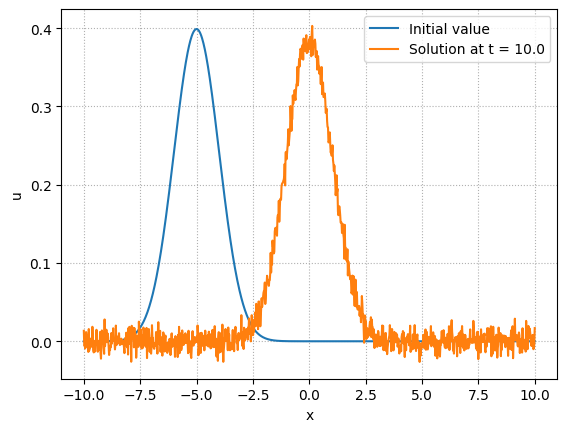

In [44]:
from PINN.PhysicsInformedROPDF import *
# Testing
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy

# set random seeds
np.random.seed(10)
torch.manual_seed(10);

import numpy as np    
import matplotlib.pyplot as plt

class LinearAdvection1D:
    # Matrix for LA1D 
    A=0
   # Initialization of constants 
    def __init__(self, c, x0, xN, N, deltaT,T):
        self.c = c 
        self.x0 = x0   
        self.xN = xN 
        self.N = N   
        self.deltaT = deltaT   
        self.T = T       
    # CFL number funct.   
    def CFL(self):
        deltaX= (self.xN - self.x0)/self.N
        return np.abs(self.c*self.deltaT/deltaX)
    # check CFL number <=1 or not.
    def checkCFL(self):
        if (self.CFL()<=1):
            flag=True
        else:
            flag=False
        return flag
    # Matrix assembly of LA1D   
    def upwindMatrixAssembly(self):
        alpha_min=min(self.CFL(),0)
        alpha_max=max(self.CFL(),0)
        a1=[alpha_max]*(self.N-1)
        a2=[1+alpha_min-alpha_max]*(self.N)
        a3=[-alpha_min]*(self.N-1)
        self.A=np.diag(a1, -1)+np.diag(a2, 0)+np.diag(a3, 1)

    # Solve u=Au0
    def step(self,u0):
        return np.matmul(self.A,u0) 

#############  
# Start of the code
###################

# constants  
N, x0, xN, deltaT, c, T = 1000, -10.,10., 0.01, 0.5, 10.0
# initialization of constants
LA1D = LinearAdvection1D(c, x0, xN, N, deltaT,T) 

# initial value
x = np.linspace(LA1D.x0,LA1D.xN,LA1D.N)
nx = len(x)
u0=(1/(np.sqrt(2*np.pi)))*np.exp(-0.5*((x+5)**2))

#plot of initial value    
plt.plot(x,u0,label="Initial value")
plt.ylabel('u')
plt.xlabel('x')
plt.legend()

# save solutions
nt = int(LA1D.T/LA1D.deltaT)
tgrid = np.linspace(0, T, nt)
u_sol = np.zeros([nt, nx])


# calculating solution if CFL<=1
if LA1D.checkCFL():
    print("CFL number is: ", LA1D.CFL())
    LA1D.upwindMatrixAssembly()
    for i in range(0, nt):
        u_sol[i, :] = u0
        u = LA1D.step(u0)
        u0 = u
else:
    print("CFL number is greater than 1. CFL: ", LA1D.CFL())

u_sol = u_sol + 0.01 * np.random.randn(u_sol.shape[0], u_sol.shape[1])
# ploting the last solution
plt.plot(x,u_sol[-1, :],label="Solution at t = {}".format(LA1D.T))
plt.legend()
plt.grid(linestyle='dotted')

# save data for testing
scipy.io.savemat("../data/LinearOscillator/Pure_Advection.mat", {
    "xgrid": x.reshape(1, -1),
    "tgrid": tgrid.reshape(1, -1),
    "pmc": u_sol
})

# save a smaller dataset
subsample_t = 2
subsample_x = 5
scipy.io.savemat("../data/LinearOscillator/Pure_Advection_small_data.mat", {
    "xgrid": x.reshape(1, -1)[:, 0:-1:subsample_x],
    "tgrid": tgrid.reshape(1, -1)[:, 0:-1:subsample_t],
    "pmc": u_sol[0:-1:subsample_t, 0:-1:subsample_x]
})
print("Training data size = {}\n".format(u_sol[0:-1:subsample_t, 0:-1:subsample_x].shape))

In [45]:
# inverse problem with PINN
#data_path = "../data/LinearOscillator/Pure_Advection.mat"
# subsampled spatial training data
data_path = "../data/LinearOscillator/Pure_Advection_small_data.mat"
# create PINN
pinn = PhysicsInformedROPDF(indim=2, outdim=1, data_path=data_path, scheduler="ExponentialLR")
print(
    pinn.G_nn
)


------------------------------------------------------------

=> Data Loaded at: ../data/LinearOscillator/Pure_Advection_small_data.mat 

----> Total Number of observations = 98802 

------------------------------------------------------------

G_Net(
  (net): DNN(
    (layers): Sequential(
      (layer_0): Linear(in_features=2, out_features=32, bias=True)
      (activation_0): Tanh()
      (layer_1): Linear(in_features=32, out_features=32, bias=True)
      (activation_1): Tanh()
      (layer_2): Linear(in_features=32, out_features=32, bias=True)
      (activation_2): Tanh()
      (layer_3): Linear(in_features=32, out_features=1, bias=True)
      (activation_3): Softplus(beta=1, threshold=20)
    )
  )
)


In [14]:
# testing PINN 
cartesian_data(pinn.tgrid.clone().detach().numpy().flatten(), np.array([pinn.xmin, pinn.xmax]).flatten())

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

In [ ]:
# testing training
info = train(
    pinn, pinn.optimizer, pinn.scheduler, batch_size=2**10,
    epochs=300, batch_print=50, mode="all"
)

------------------------------------------------------------------

|                      Epoch 1                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 51 |

---------- 

++ Learning rate reduced, now at = 0.001960
Batch PDE Loss = 0.0001913310767426583 

Batch Data Loss = 0.01975252136761048 

------------------------------------------------------------------

|                      Epoch 2                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 51 |

---------- 

++ Learning rate reduced, now at = 0.001941
Batch PDE Loss = 8.25565516346246e-05 

Batch Data Loss = 0.0025622465084297174 

------------------------------------------------------------------

|                      Epoch 3                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 51 |

---

| => | Batch 51 |

---------- 

++ Learning rate reduced, now at = 0.001587
Batch PDE Loss = 6.298222090602202e-06 

Batch Data Loss = 0.00011004773531188022 

------------------------------------------------------------------

|                      Epoch 23                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 51 |

---------- 

++ Learning rate reduced, now at = 0.001571
Batch PDE Loss = 6.0272748092178885e-06 

Batch Data Loss = 0.00010923315973378955 

------------------------------------------------------------------

|                      Epoch 24                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 51 |

---------- 

++ Learning rate reduced, now at = 0.001556
Batch PDE Loss = 6.335306407404851e-06 

Batch Data Loss = 0.00012713363711929081 

------------------------------------------------------------------

|      

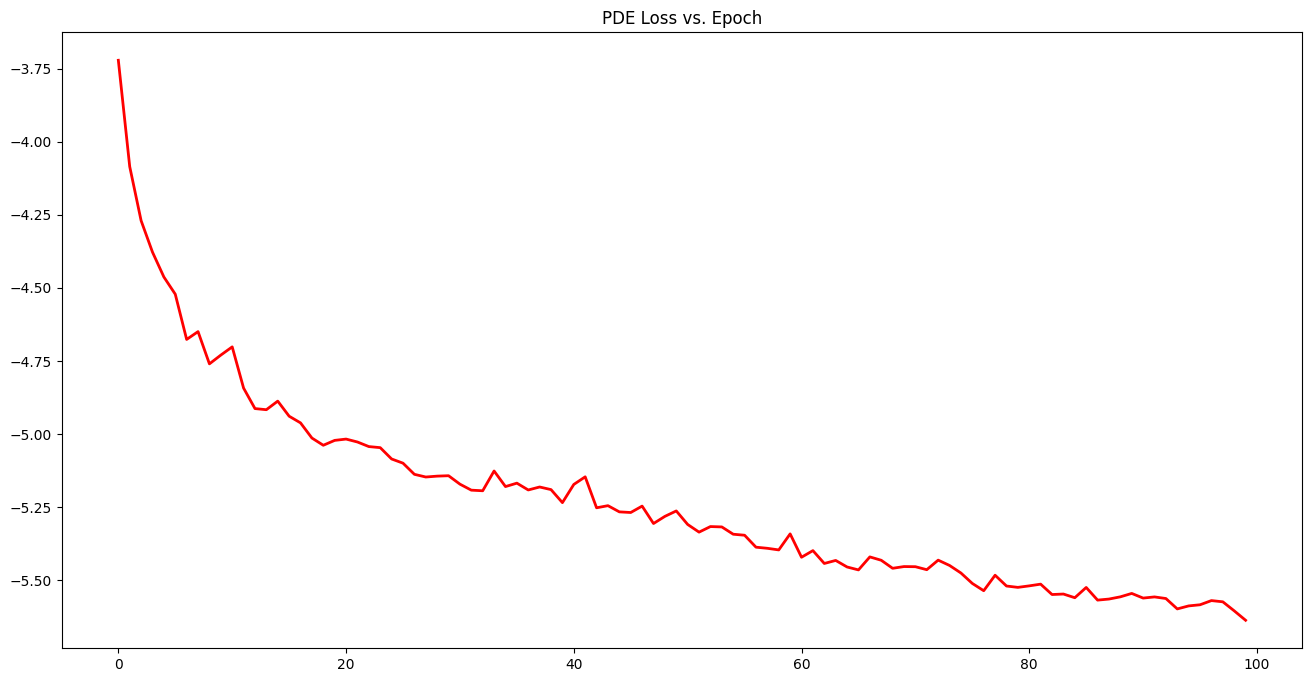

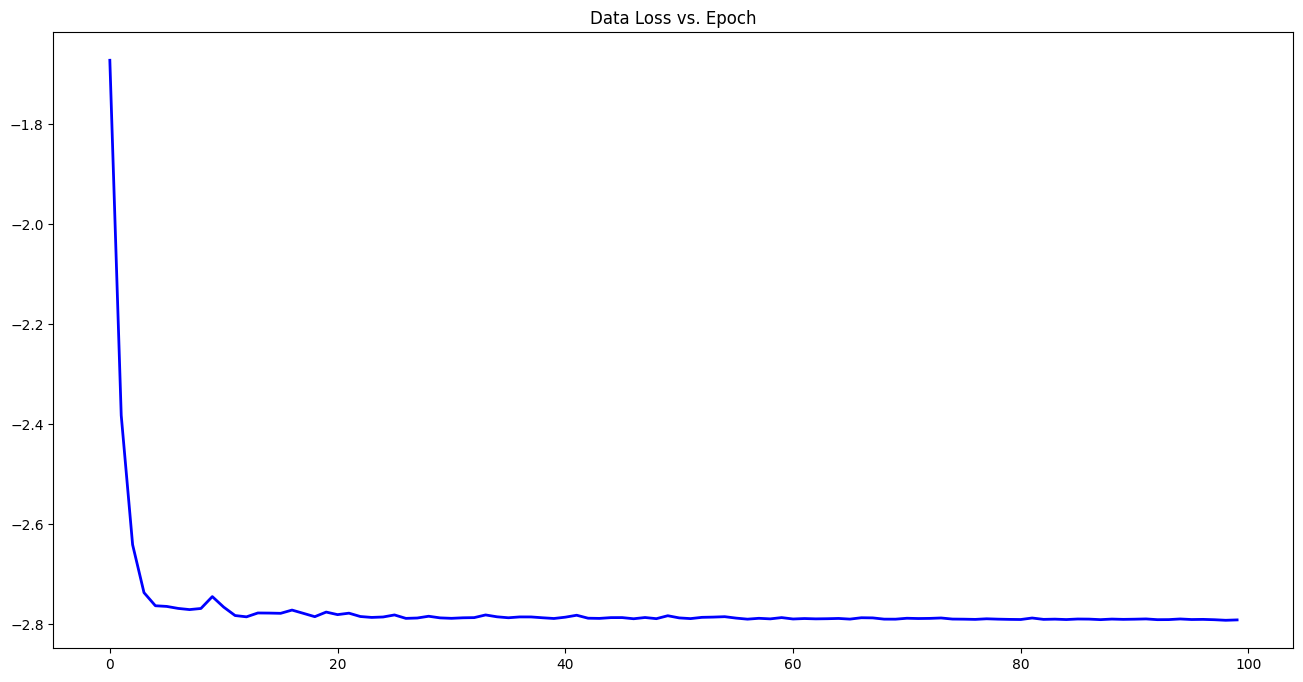

In [32]:
# visualize losses
plt.figure(1, figsize=(16, 8));
plt.plot(np.log10(info["pde_loss"]), lw=2, color="red");
plt.title("PDE Loss vs. Epoch");

plt.figure(2, figsize=(16, 8));
plt.plot(np.log10(info["data_loss"]), lw=2, color="blue");
plt.title("Data Loss vs. Epoch");

# plt.figure(3, figsize=(16, 8));
# plt.plot(np.log10(info["reg_loss"]), lw=2, color="purple");
# plt.title("Regularity Loss vs. Epoch");

In [33]:
query = cartesian_data(pinn.tgrid, pinn.xgrid)

D_pred = pinn.D_nn(query).reshape(pinn.nx, pinn.nt).T.detach().numpy()
G_pred = pinn.G_nn(query).reshape(pinn.nx, pinn.nt).T.detach().numpy()
p_pred = pinn(query).reshape(pinn.nx, pinn.nt).T.detach().numpy()

# grids
tgrid = pinn.tgrid.detach().numpy()
xgrid = pinn.xgrid.detach().numpy()

p_exact = pinn.raw_data["pmc"]
dx = pinn.dx.item()
dt = pinn.dt.item()

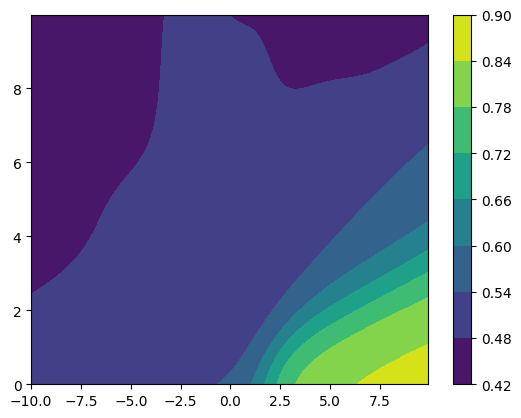

In [34]:
plt.figure(1);
plt.contourf(xgrid, tgrid, G_pred);
plt.colorbar();

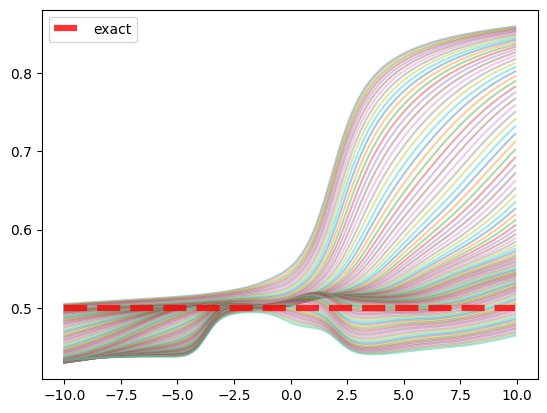

In [35]:
plt.figure(1);
plt.plot(xgrid, G_pred[0:-1:5, :].T, alpha=0.4, lw=1.5);
plt.plot(xgrid, 0.5*np.ones_like(xgrid), "--", lw=4.5, color="red", alpha=0.8, label="exact");
plt.legend();

In [36]:
nx = 800
xgrid_fine = np.linspace(-10.0, 10.0, nx)
xgrid_fine = torch.tensor(xgrid_fine)
dx = xgrid_fine[1]-xgrid_fine[0]
nt = 1000
tgrid_fine = np.linspace(0., 10.0, nt)
tgrid_fine = torch.tensor(tgrid_fine)
dt = tgrid_fine[1]-tgrid_fine[0]

query_fine = cartesian_data(tgrid_fine, xgrid_fine)

D_pred_fine = pinn.D_nn(query_fine).reshape(nx, nt).T.detach().numpy()
G_pred_fine = pinn.G_nn(query_fine).reshape(nx, nt).T.detach().numpy()
p_pred_fine = pinn(query_fine).reshape(nx, nt).T.detach().numpy()

(1000, 800)


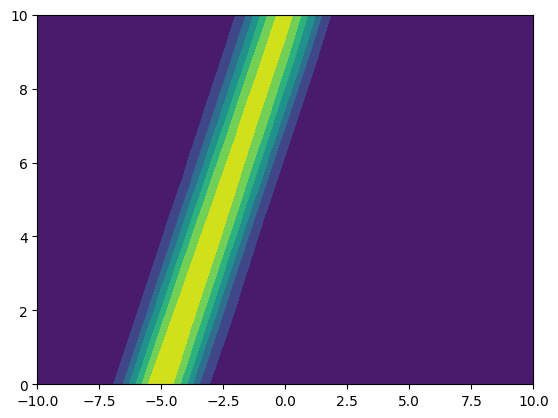

In [37]:
# interpolation
print(p_pred_fine.shape)
plt.contourf(xgrid_fine.detach().numpy(), tgrid_fine.detach().numpy(), p_pred_fine);

(500, 200)


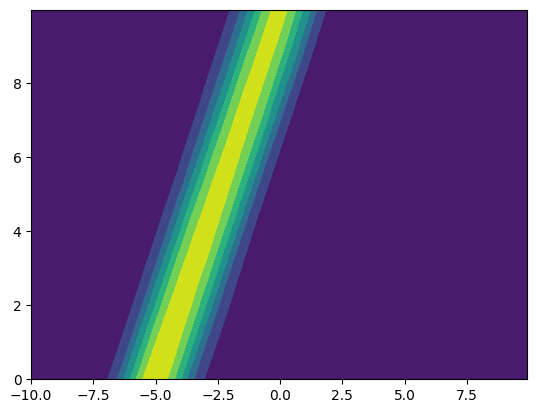

In [38]:
# reconstruction on training dataset
print(p_pred.shape)
plt.contourf(pinn.xgrid.detach().numpy(), pinn.tgrid.detach().numpy(), p_pred);

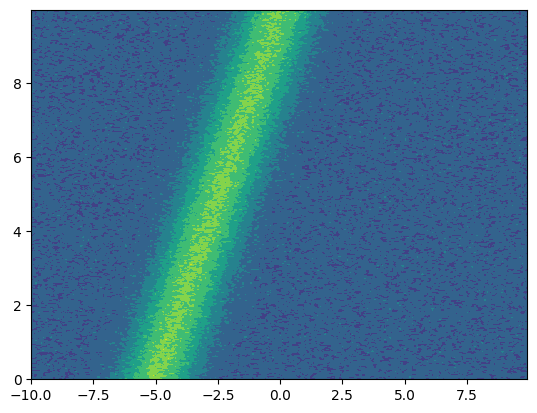

In [39]:
plt.contourf(pinn.xgrid.detach().numpy(), pinn.tgrid.detach().numpy(), pinn.raw_data["pmc"]);

In [ ]:
plt.figure(2);
# relative error in L^2 from KDE benchmark
l2_rel_err = np.sum(((p_pred-p_exact)**2)*dx, 1) / np.sum((p_exact**2)*dx, 1)
tgrid = pinn.tgrid.detach().numpy()
plt.plot(tgrid, l2_rel_err, color="red", lw=1.5);
plt.grid(True);
plt.title(r"Relative error in $L^2$");
plt.xlabel(r"$t$"); 
plt.ylabel(r"$L^2(\mathbb{R})$ error");

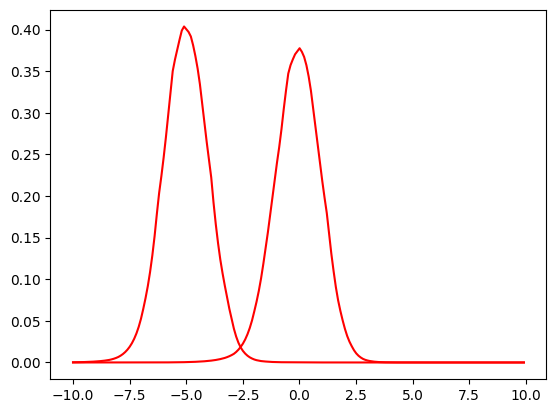

In [40]:
plt.figure(1);
plt.plot(xgrid, p_pred[0, :], xgrid, p_pred[-1, :], color="red");
#plt.plot(xgrid, p_exact[0, :], xgrid, p_exact[-1, :], color="green");

In [42]:
# save trained model
epoch = 100
model_path = "./PINN/models/const_advection_model_epoch{}".format(epoch)
torch.save(pinn.state_dict(), model_path)